In [2]:
import os
import sys  
import rasterio

import pandas as pd

from rasterio.plot import show

import numpy as np

#from PIL import Image

import matplotlib.pyplot as plt

from geneticalgorithm import geneticalgorithm as ga

root = os.getcwd() + "/.."

sys.path.insert(0, root)
import src.camera_allocation_functions as aptitude

from sys import getsizeof
from IPython.display import clear_output

In [3]:

fp1 = '../data/processed/aguascalientes/00_clossenes_to_streets_normalized_ags'
walls = rasterio.open(fp1)

fp2 = '../data/processed/aguascalientes/01_densidad_delitos_sobre_calle_1998'
crime_density = rasterio.open(fp2)

fp3 = '../data/processed/aguascalientes/02_manzanas_raster_binary'
blocks = rasterio.open(fp3)

fp4 = '../data/processed/aguascalientes/delitos_ags_2018_raster_bin'
crime = rasterio.open(fp4)
C = crime.read(1)
#crime = crime_density.read(1)

#correction
S = blocks.read(1)
S[S==255] = 0

CD = crime_density.read(1)

W = walls.read(1)

Text(0.5, 0.98, 'Required Maps')

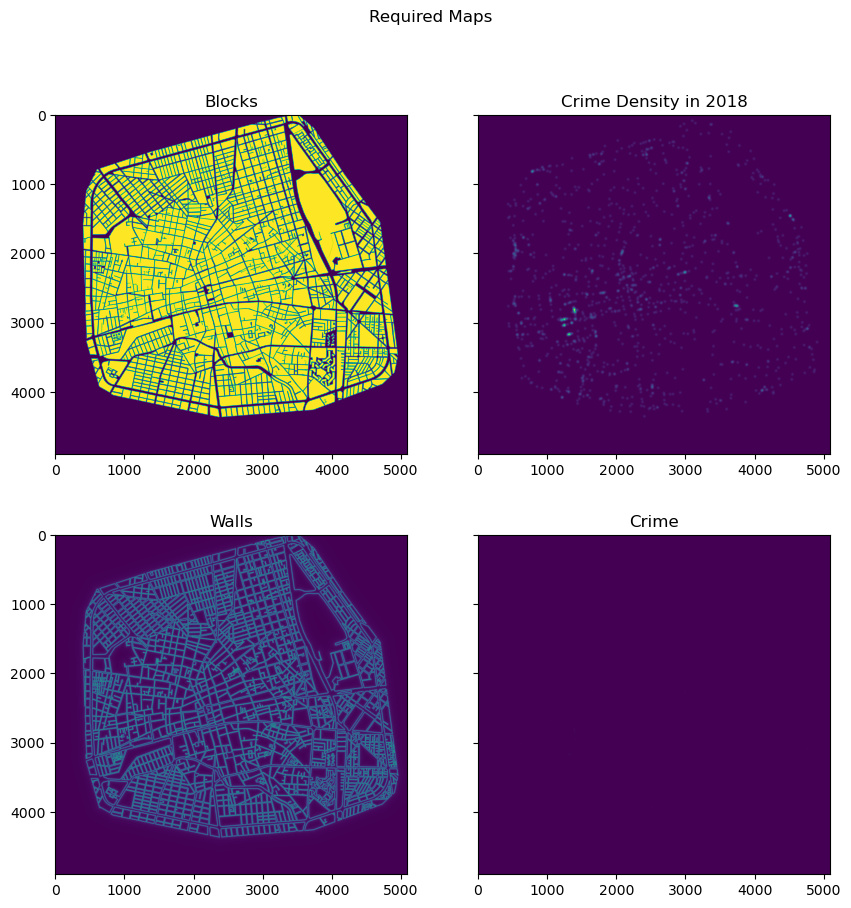

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

axs[0][0].set_title("Blocks")
axs[0][0].imshow(S)

axs[1][0].set_title("Walls")
axs[1][0].imshow(W)

axs[0][1].set_title("Crime Density in 2018")
axs[0][1].imshow(CD)

axs[1][1].set_title("Crime")
axs[1][1].imshow(C)

fig.suptitle('Required Maps')

## Union de Todas las Isovistas posibles que cubren la densidad de delitos

Text(0.5, 1.0, '1777374')

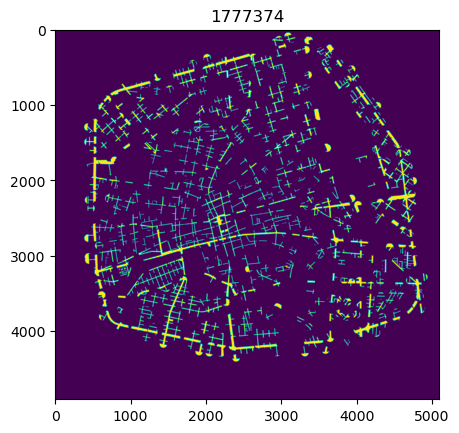

In [6]:
K = aptitude.gkern(50*2 + 1, 4)
ndens = CD*(S==0)*np.max(K)
plt.imshow(ndens > 0)
plt.title(np.sum(ndens > 0))

**Leyendo las posiciones con su fitness**

Text(0.5, 1.0, 'Indices de criminalidad ordenados de mayor a menor')

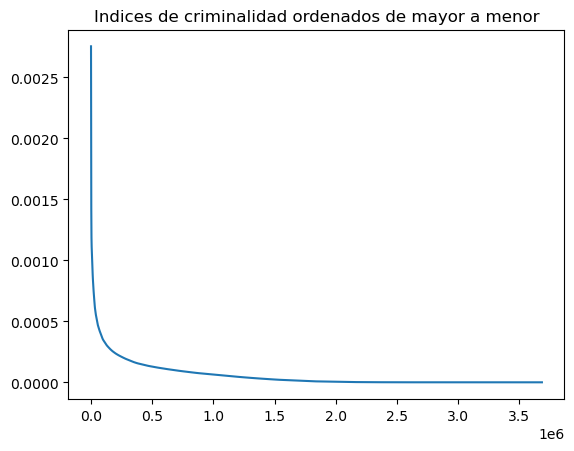

In [7]:
DF = pd.read_csv("../data/processed/aguascalientes/fitness_positions_vc_area.csv")

#ordenando por coeficiente de visibilidad
rank = "visibility coefficient"
DF_sort = DF[1:].sort_values(by = [rank], ascending = False)
plt.plot(np.array(DF_sort[:][rank]))
plt.title("Indices de criminalidad ordenados de mayor a menor")


#descartando las posiciones cercanas a la mejor
## Algoritmo Greedy
**El resultado se guarda en DF_init.**
Este proceso es rápido. Se hace en unos 3 minutos approx. 
Este resultado se puede guardar en un .csv



In [8]:
# se debería llamar R de Radio
radius = 50

#Ordenar las posiciones de acuerdo a su indice de visibilidad (DF_init)

#seleccionar la mejor posición 
DF_init = DF_sort.iloc[[0]]


#detectar que posiciones están dentro del radio 
selected_rows = ((DF_sort.iloc[0]["i"] - DF_sort["i"])**2 + (DF_sort.iloc[0]["j"] - DF_sort["j"])**2)**(0.5) >= radius

#hacer una lista con las posiciones que estan fuera del radio
DF_sort = DF_sort[selected_rows]

TOTAL = len(DF_sort)

c = 0
while len(DF_sort)>0 and np.sum(selected_rows) > 0:
    
    selected_rows = ((DF_sort.iloc[0]["i"] - DF_sort["i"])**2 + (DF_sort.iloc[0]["j"] - DF_sort["j"])**2)**(0.5)>=radius
   
    if np.sum(selected_rows)>0:
    
        DF_sort = DF_sort[selected_rows]
        DF_init = pd.concat([DF_init, DF_sort.iloc[[0]]])
    
    if c%1000==0:  
        print(100*(len(DF_sort)/TOTAL),'%')
    
    c += 1
        

99.87356175134354 %
48.89404550799336 %
21.212161534638813 %
3.9307196606588586 %


In [13]:
# tenemos 3661 posiciones de camaras
len(DF_init)

3661

In [14]:
# DF_init contiene todas las camaras. 

#n_sensors = len(DF_init)
#X_resh tiene las posiciones asociadas a los indices de criminalidad
Xresh = np.array(DF_init.iloc[:][["i","j"]]).astype(int)


In [21]:
## En este bloque es donde ha estado el cuello de botella. 
# la evaluación de las camaras es muy costosa en memoria como estaba antes.
# En esta versión, tenemos solo una matriz ONE_COVER, que va guardando el mejor indice de criminalidad observado y una sola matriz SENSORS, que guarda el sensor asociado a ese indice de criminalidad

In [22]:


K = aptitude.gkern(radius*2 + 1, 4)
Kth = 0.000001
radius = 50

#el mapa 0 siempre apunta a la mejor camara
SENSORS = np.zeros((2, S.shape[0], S.shape[1]))
VALUES = np.zeros((2, S.shape[0], S.shape[1]))

ONE_COVER = np.zeros((S.shape[0], S.shape[1]))


#Justo aquí estaba el cuello de botella, si ns: numero de sensores 
# era muy alto se saturaba la memoria. Aqui se resuelte el problema usando Buble sort para guardar el mejor indice, sensor, en dos matrices bidimensionales
ns = len(Xresh)
ns = 100
F = list([])
for i, x in enumerate(Xresh[0:ns]):
    
    clear_output(wait=True)
    print("{:.2f}%".format(100*i/ns))

  ####

    si = tuple(Xresh[i])
    
    #Z = np.zeros((radius*2+1, radius*2+1))
    #Z[(radius*2, radius*2)] = 1
    
    #street
    S_sub = np.copy(S[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    
    #Crime density
    CD_sub = np.copy(CD[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    
    
    C_sub = np.copy(C[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    isovist = aptitude.isovista(S_sub)
    K = aptitude.gkern(radius*2 + 1, 4)

    ONE_COVER[si[0]-radius : si[0] + radius + 1, si[1]-radius:si[1]+radius+1] = isovist*K*CD_sub
   
  ##
    
    VALUES[1] = ONE_COVER

    
    SENSOR_AUX = np.argmax(VALUES, axis=0)*(i+1)
    VALUES_AUX = np.max(VALUES, axis=0)

    #best camera is stored in sensors
    SENSORS[0] = ((SENSOR_AUX==0)*SENSORS[0]+(SENSOR_AUX!=0)*SENSOR_AUX).astype(int)

    #best criminality indexes values are stored in VALUES[0]
    VALUES[0] =  VALUES_AUX

    B = np.sum(np.max(K)*(S==0)*CD)
    A = np.sum(VALUES[0])
    F.append(A/B)
    print("Fitness:", A/B)
    #plt.plot(F)
    #plt.show()


99.00%
Fitness: 0.1621222003630082


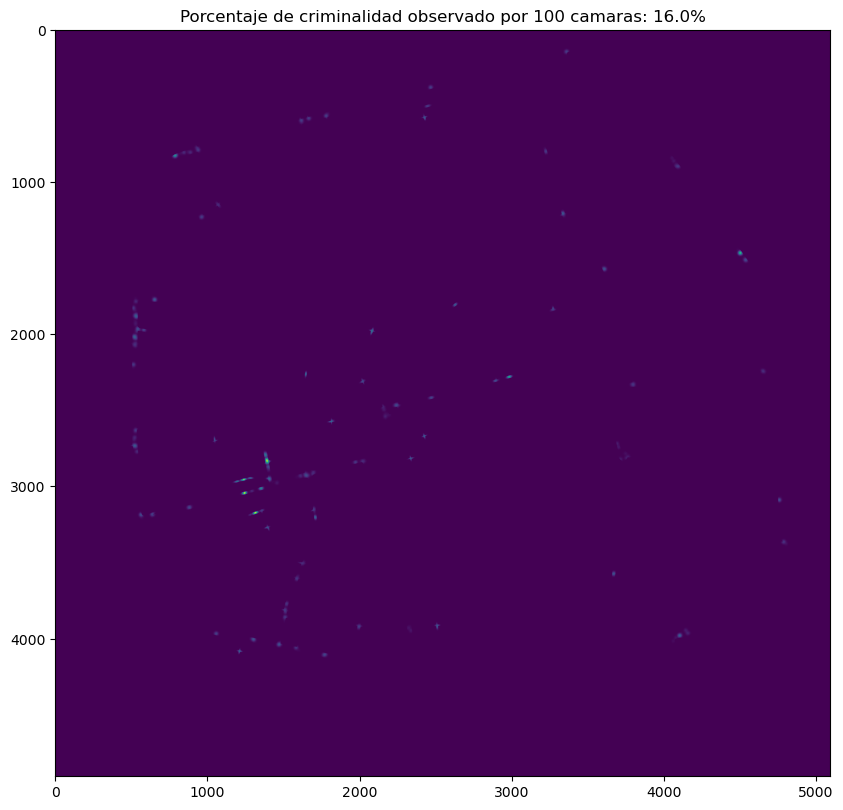

In [26]:
plt.figure(figsize=(10, 10))

B = np.sum(np.max(K)*(S==0)*CD)
A = np.sum(VALUES[0])

plt.imshow(VALUES[0])
plt.title("Porcentaje de criminalidad observado por {ns} camaras: {p}%".format(ns=ns, p=100*round(A/B,2)))
plt.show()




Text(0, 0.5, 'Fitness en Indice de criminalidad')

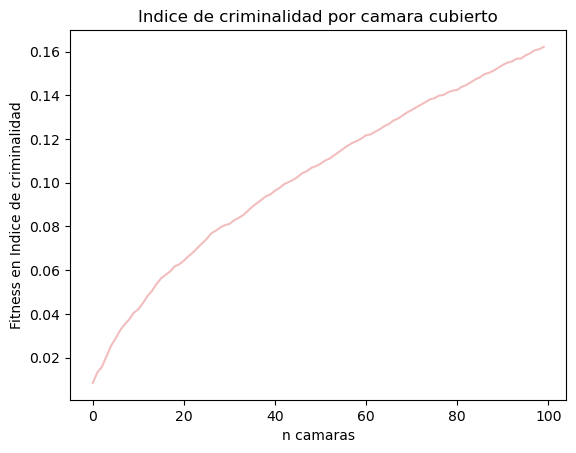

In [27]:
plt.plot(F, color = "tab:red", alpha = 0.3)
plt.title("Indice de criminalidad por camara cubierto")
plt.xlabel("n camaras")
plt.ylabel("Fitness en Indice de criminalidad")

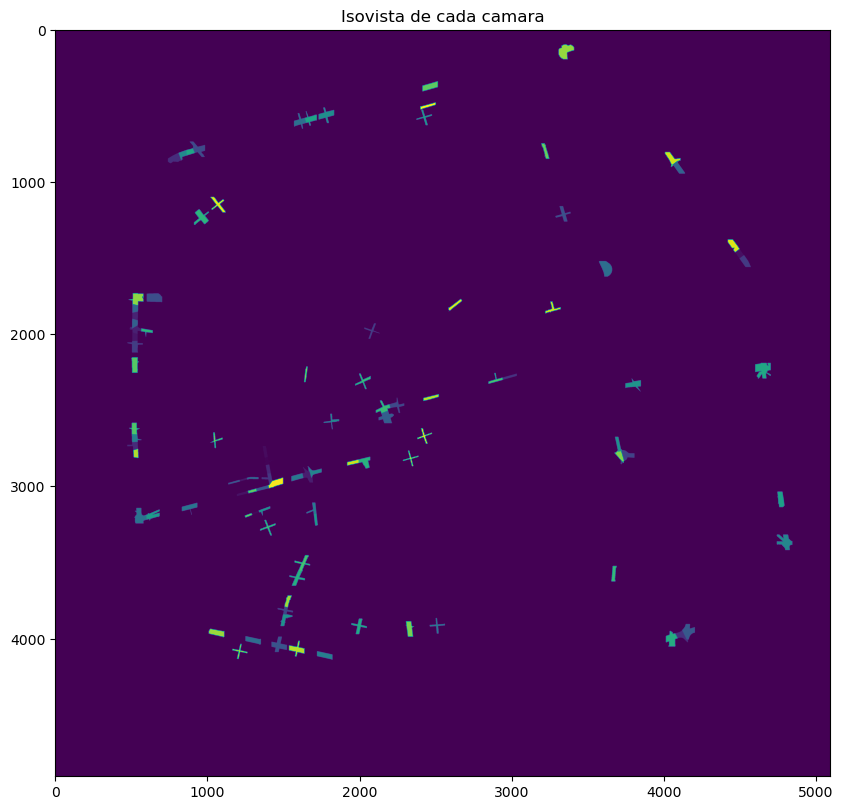

In [28]:
plt.figure(figsize=(10, 10))

B = np.sum(np.max(K)*(S==0)*CD)
A = np.sum(VALUES[0])

plt.imshow(SENSORS[0])
plt.title("Isovista de cada camara")
plt.show()


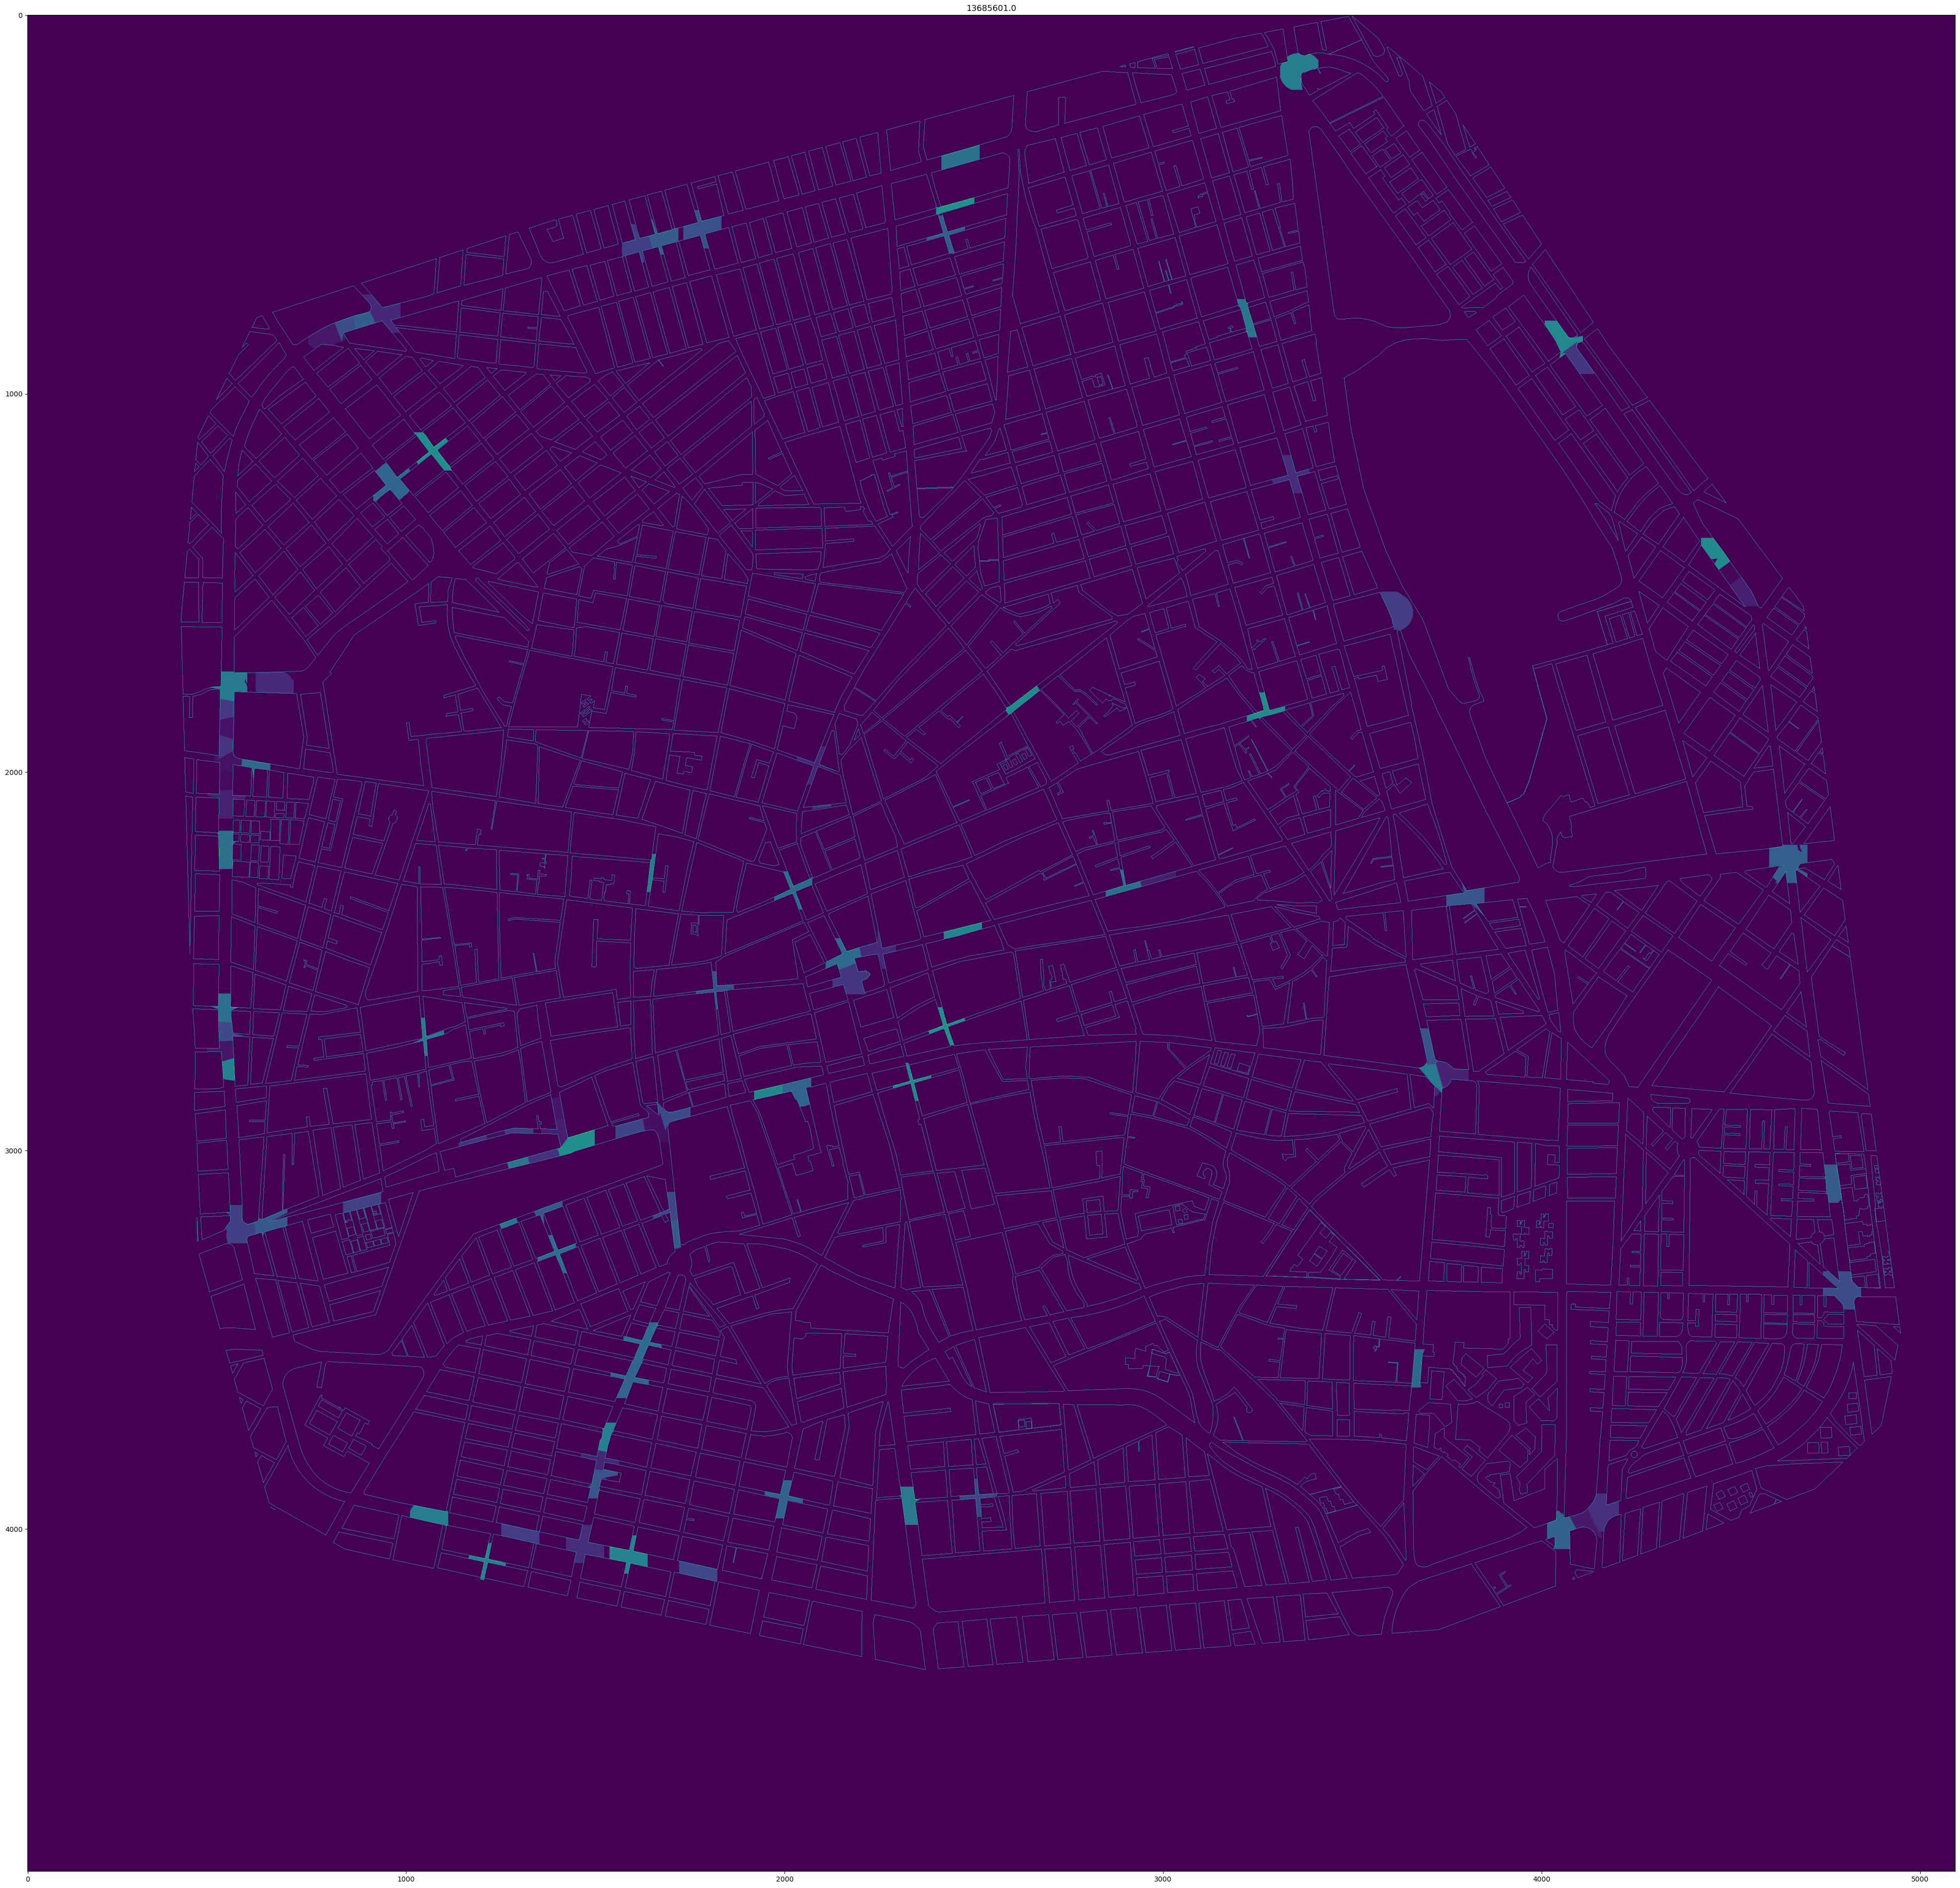

In [31]:
plt.figure(figsize=(50, 50))

plt.imshow((SENSORS[0]) + (W==1)*np.max(SENSORS[0]))
plt.title(np.sum(SENSORS[0]))
plt.savefig("solution for the {n} best cameras.png".format(n=ns))

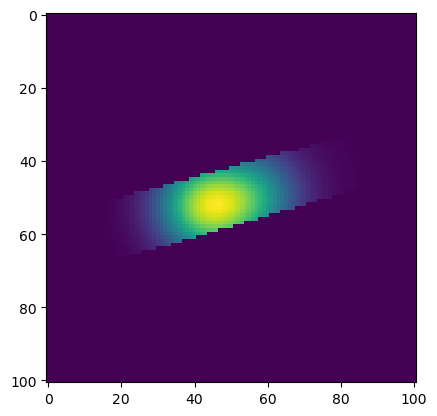

In [33]:
plt.imshow(isovist*K*CD_sub)

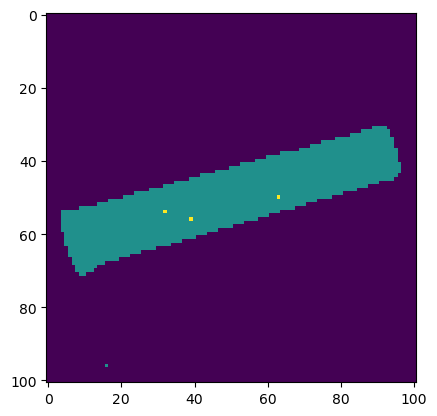

In [34]:
plt.imshow(C_sub+(isovist*(K>0.000001)))

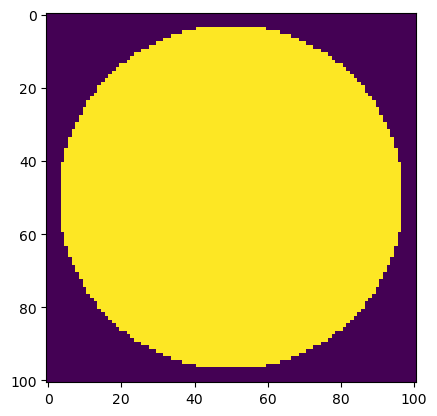

In [35]:
#radio de visión de una camara 360
plt.imshow(K>0.000001)

Text(0.5, 1.0, 'número de delitos : 3')

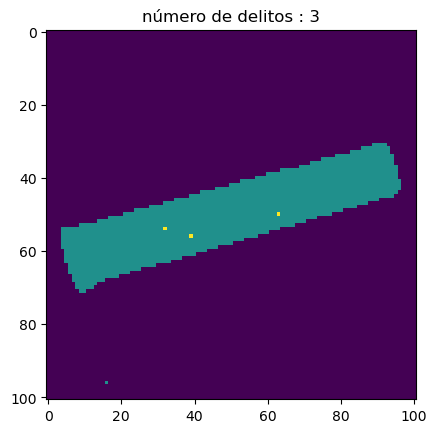

In [36]:
# delitos detectados dentro del radio de visión y la isovista
plt.imshow(C_sub+(isovist*(K>0.000001)))
plt.title("número de delitos : {n}".format( n= np.sum((C_sub*isovist*K>0.000001))))

Text(0.5, 1.0, 'número de delitos : 3')

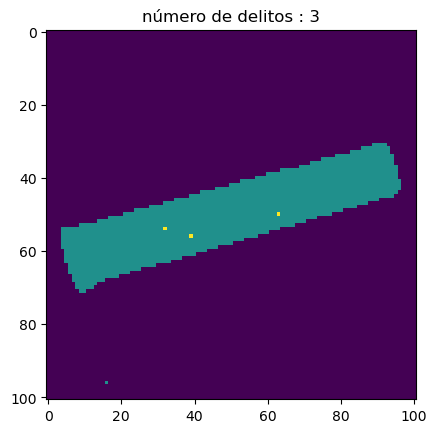

In [37]:
des# delitos detectados dentro del radio de visión y la isovista
plt.imshow(C_sub+(isovist*(K>0.000001)))
plt.title("número de delitos : {n}".format( n= np.sum((C_sub*isovist*K>0.000001))))